### Multi-input Autoencoder model on CTG dataset
- Load Data
- Preprocess Data
- Perform PCA on Data
- Divide Dataset in 2 smaller datasets of fewer features
- Define Multi-input Autoencoder Model
- Train Model
- Generate predictions for Train and Test Sets (Encode Data)
- Perform PCA on Encoded Data
- Evaluate generated data on classification models

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')

In [2]:
# Preprocess Data
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [3]:
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

In [4]:
# Divide the dataset into 2 subsets with fewer features, approximately in half.
X_train_first = X_train_norm.iloc[:,:11]
X_train_second = X_train_norm.iloc[:,11:]
X_test_first = X_test_norm.iloc[:,:11]
X_test_second = X_test_norm.iloc[:,11:]

In [5]:
print(X_train_first.shape[1])

11


_____________________________
### PCA

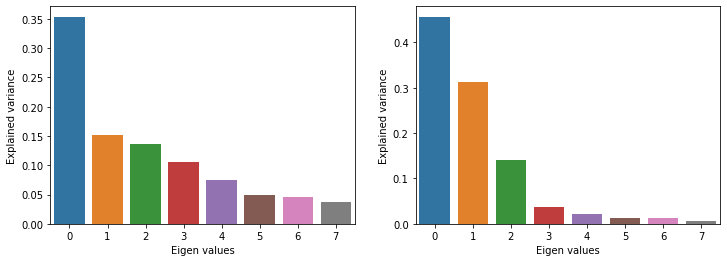

Simple PCA explained variance ratio: 0.9532509737517163
Simple PCA explained variance ratio: 0.9981810237813068


In [6]:
# Perform PCA to find the most significant features
from sklearn.decomposition import PCA
# select the number of components
pca_first = PCA(n_components = 8)
X_train_pca_first = pca_first.fit_transform(X_train_first)
X_test_pca_first = pca_first.transform(X_test_first)

pca_second = PCA(n_components = 8)
X_train_pca_second = pca_second.fit_transform(X_train_second)
X_test_pca_second = pca_second.transform(X_test_second)

x_pca_train_first_labeled = np.c_[X_train_pca_first , y_train]
x_pca_test_first_labeled = np.c_[X_test_pca_first , y_test]
x_pca_train_second_labeled = np.c_[X_train_pca_second , y_train]
x_pca_test_second_labeled = np.c_[X_test_pca_second , y_test]


plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sns.barplot(np.arange(np.shape(pca_first.explained_variance_ratio_)[0]),pca_first.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

ax1 = plt.subplot(1,2,2)
sns.barplot(np.arange(np.shape(pca_second.explained_variance_ratio_)[0]),pca_second.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

print(f"Simple PCA explained variance ratio: {pca_first.explained_variance_ratio_.sum()}")
print(f"Simple PCA explained variance ratio: {pca_second.explained_variance_ratio_.sum()}")


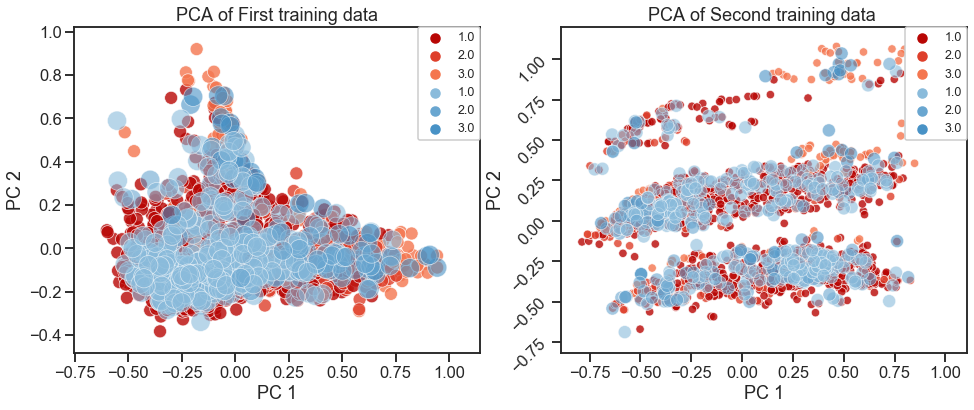

In [7]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=x_pca_train_first_labeled[:,0], 
                y=x_pca_train_first_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=x_pca_train_first_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_first_labeled[:,0],
                y=x_pca_test_first_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=x_pca_test_first_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of First training data")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=x_pca_train_second_labeled[:,0], 
                y=x_pca_train_second_labeled[:,1], 
                alpha = 0.8, 
                s= 70, legend='full', 
                hue=x_pca_train_second_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_second_labeled[:,0],
                y=x_pca_test_second_labeled[:,1],
                alpha = 0.6, 
                s= 170, 
                legend='full',
                hue=x_pca_test_second_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of Second training data ")

plt.yticks(rotation=45) 
plt.show()

__________________________________________
### Autoencoder

In [8]:
from typing import Tuple

# ToDo: Try Batch Normalization and Dropout layers
# Define de multi-input multi-output model using the keras functional API
def build_multi_autoencoder(encoding_dim: int, number_features: Tuple, regularizer: tf.keras.regularizers.Regularizer):
    """Two-input autoencoder build function
       Parameters: encoding_dim: Size of the latent space (bottleneck layer size).
                   number_features: Tuple with the sizes of the two inputs.
                   regularizer: keras regularizer object
       Returns the 3 models: full autoencoder, the encoder part and the decoder part
    """
    # this is the reduction of our encoded representations, in times.
    print(f"Compression: {sum(number_features)/encoding_dim}")

    ## First Dataset input path
    # encoder first input placeholder.
    first_input = layers.Input(shape=(number_features[0]))
    # encoder first path first Hidden Layer - H11
    H11 = layers.Dense(32, activation='relu', kernel_regularizer=regularizer)(first_input)
    # encoder first path first Batch Normalization Layer - BN11
    BN11 = layers.BatchNormalization()(H11)
    # encoder first path first Dropout Layer - D11
    D11 = layers.Dropout(0.5)(BN11)
    # encoder first path second Hidden Layer - H12
    H12 = layers.Dense(16, activation='relu', kernel_regularizer=regularizer)(D11)
    # encoder first path second Batch Normalization Layer - BN12
    BN12 = layers.BatchNormalization()(H12)
    # encoder first path second Dropout Layer - D12
    D12 = layers.Dropout(0.5)(BN12)
   
    ## Second Dataset input path
    # encoder second input placeholder
    second_input = layers.Input(shape=(number_features[1]))
    # encoder second path first Hidden Layer - H21
    H21 = layers.Dense(32, activation='relu', kernel_regularizer=regularizer)(second_input)
    # encoder second path first Batch Normalization Layer - BN21
    BN21 = layers.BatchNormalization()(H21)
    # encoder second path first Dropout Layer - D21
    D21 = layers.Dropout(0.5)(BN21)
    # encoder second path second Hidden Layer - H22
    H22 = layers.Dense(16, activation='relu', kernel_regularizer=regularizer)(D21)
    # encoder second path second Batch Normalization Layer - BN22
    BN22 = layers.BatchNormalization()(H22)
    # encoder second path second Dropout Layer - D22
    D22 = layers.Dropout(0.5)(BN22)
    
    ## Concatenate paths - Bottleneck 
    concatenated = layers.concatenate([D12, D22], axis=-1)
    bottleneck = layers.Dense(encoding_dim, activation='relu', kernel_regularizer=regularizer)(concatenated)

    # this model maps an input to its encoded representation
    encoder = keras.models.Model([first_input,second_input], bottleneck, name='encoder')

    ## Decoder Outputs
    # Decoder Input Layer - Encoding dimension - D1
    encoded_input = layers.Input(shape=(encoding_dim,))
    # Main joint output hidden layer - D1 
    D1 = layers.Dense(32, activation='relu', kernel_regularizer=regularizer)(encoded_input)
    
    ## Paths Split
    ## First Dataset output path
    # decoder first path first Batch Normalization Layer - BN13 
    BN13 = layers.BatchNormalization()(D1)
    # decoder first path first Dropout Layer - D13
    D13 = layers.Dropout(0.5)(BN13)
    # decoder first path first Hidden Layer - H13
    H13 = layers.Dense(16, activation='relu', kernel_regularizer=regularizer)(D13)
    # decoder first path second Batch Normalization Layer - BN14 
    BN14 = layers.BatchNormalization()(H13)
    # decoder first path second Dropout Layer - D14
    D14 = layers.Dropout(0.5)(BN14)
    # decoder first path reconstruction layer - O1
    O1 = layers.Dense(number_features[0], activation='sigmoid')(D14)
    
    ## Second path output hidden
    # second output hidden layer
    BN23 = layers.BatchNormalization()(D1)
    # decoder second path first Dropout Layer - D23
    D23 = layers.Dropout(0.5)(BN23)
    # decoder second path first Hidden Layer - H13
    H23 = layers.Dense(16, activation='relu', kernel_regularizer=regularizer)(D23)
    # decoder second path second Batch Normalization Layer - BN14 
    BN24 = layers.BatchNormalization()(H23)
    # decoder second path second Dropout Layer - D14
    D24 = layers.Dropout(0.5)(BN24)
    # decoder second path reconstruction layer - O1
    O2 = layers.Dense(number_features[1], activation='sigmoid')(D24)

    # create the decoder model
    decoder = keras.models.Model(encoded_input, [O1, O2])

    # create the full autoencoder
    encoder_model = encoder([first_input, second_input])
    decoder_model = decoder(encoder_model)

    autoencoder = keras.models.Model([first_input,second_input], decoder_model, name="autoencoder")
    
    autoencoder.summary()
    
    return autoencoder, encoder, decoder

In [35]:
## Call autoencoder build function and get the AE, the encoder and the decoder.
autoencoder, encoder, decoder = build_multi_autoencoder(8, (X_train_first.shape[1],X_train_second.shape[1]), tf.keras.regularizers.l2(0.00001))
# Set Optimizer: Adam with learning rate=0.001
optimizer = tf.keras.optimizers.Adam(0.001)
# Set Early Stop Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
# Compile the autoencoder using Mean Square Error loss function for both inputs.
mu = 0.5
autoencoder.compile(optimizer=optimizer,
                        loss=["mse","mse"],
                        loss_weights=[mu, 1-mu],
                        metrics=['mse'])

Compression: 2.625
Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            2440        input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 11), (None,  2085        enco

Train on 1700 samples, validate on 426 samples
Epoch 1/1000
1700/1700 [==============================] - 4s 2ms/sample - loss: 0.1821 - model_2_loss: 0.2121 - model_2_1_loss: 0.1488 - model_2_mse: 0.2119 - model_2_1_mse: 0.1495 - val_loss: 0.1182 - val_model_2_loss: 0.1404 - val_model_2_1_loss: 0.0932 - val_model_2_mse: 0.1406 - val_model_2_1_mse: 0.0930
Epoch 2/1000
1700/1700 [==============================] - 0s 152us/sample - loss: 0.1605 - model_2_loss: 0.1885 - model_2_1_loss: 0.1299 - model_2_mse: 0.1876 - model_2_1_mse: 0.1306 - val_loss: 0.1028 - val_model_2_loss: 0.1196 - val_model_2_1_loss: 0.0838 - val_model_2_mse: 0.1193 - val_model_2_1_mse: 0.0836
Epoch 3/1000
1700/1700 [==============================] - 0s 146us/sample - loss: 0.1344 - model_2_loss: 0.1578 - model_2_1_loss: 0.1071 - model_2_mse: 0.1585 - model_2_1_mse: 0.1076 - val_loss: 0.0848 - val_model_2_loss: 0.0950 - val_model_2_1_loss: 0.0711 - val_model_2_mse: 0.0953 - val_model_2_1_mse: 0.0715
Epoch 4/1000
1700/1

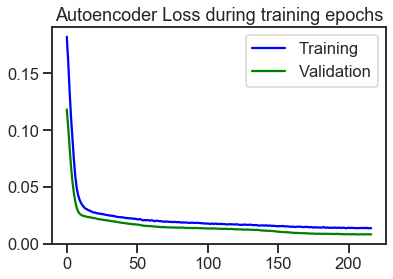

In [36]:
# Fit the training data into the autoencoder and use the test data as validation sets.
history = autoencoder.fit([X_train_first, X_train_second],[X_train_first, X_train_second],
                          validation_data=([X_test_first,X_test_second],[X_test_first,X_test_second]),
                          epochs=1000,
                          verbose=1,
                          callbacks=[early_stop])
# Plot training vs validation losses
plt.plot(history.history["loss"], c = 'b', label = "Training")
plt.plot(history.history["val_loss"], c = 'g', label = "Validation")
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.show()

In [37]:
print(history.history["val_loss"][-1])
print(history.history["loss"][-1])

0.008488623224233797
0.013896986763266957


In [38]:
## Encode datasets
X_train_encoded = encoder.predict([X_train_first, X_train_second])
X_test_encoded = encoder.predict([X_test_first, X_test_second])

In [39]:
## Renormalize data
# Renormalize input
scaler = MinMaxScaler()
X_train_encoded = pd.DataFrame(scaler.fit_transform(X_train_encoded))
X_test_encoded = pd.DataFrame(scaler.transform(X_test_encoded))

______________________________________
### PCA on encoded data

In [40]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

X_train_pca_labeled = np.c_[X_train_pca , y_train]
X_test_pca_labeled = np.c_[X_test_pca , y_test]

Simple PCA explained variance ratio: 0.9893317137105199


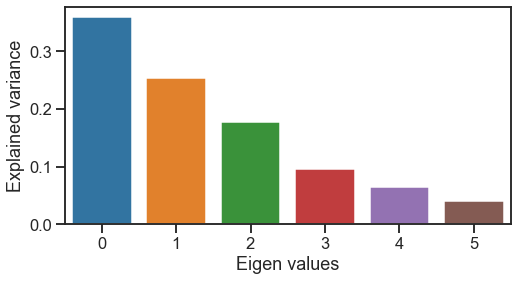

In [41]:
plt.figure(figsize=(8, 4))
sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

print(f"Simple PCA explained variance ratio: {pca.explained_variance_ratio_.sum()}")

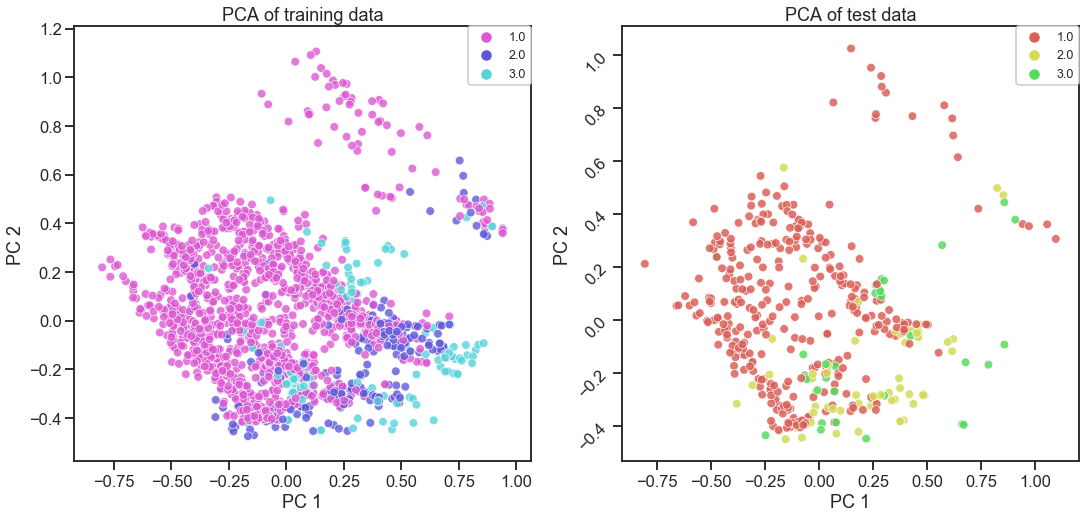

In [42]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=X_train_pca_labeled[:,0], 
                y=X_train_pca_labeled[:,1], 
                alpha = 0.8, 
                s= 75, legend='full', 
                hue=X_train_pca_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (20,10) )
ax1.set_title("PCA of training data")


ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=X_test_pca_labeled[:,0],
                y=X_test_pca_labeled[:,1],
                alpha = 0.85, 
                s= 75, 
                legend='full',
                hue=X_test_pca_labeled[:,-1], 
                palette=sns.color_palette("hls")[:3])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (18,8) )
ax1.set_title("PCA of test data")

plt.yticks(rotation=45) 
plt.show()

______________________
### DNN Classifier

In [32]:
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

In [33]:
## Test the encoded input on the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(penalization: int, input_shape):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=(input_shape,)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(64,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Set Early Stop Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)

In [34]:
# Fit best model with original dimension data
best_model = build_best_model(0.00001, len(X_train_norm.keys()))
history = best_model.fit(X_train_norm, y_train_oh, epochs=100,
                    validation_split = 0.05, verbose=0, callbacks=[early_stop])
hist = pd.DataFrame(history.history)

test_loss, test_acc = best_model.evaluate(X_test_norm, y_test_oh)

# Fit best model with reduced dimension data
encoded_model = build_best_model(0.00001, len(X_train_encoded.keys()))
history_encoded = encoded_model.fit(X_train_encoded, y_train_oh, epochs=100,
                    validation_split = 0.05, verbose=0, callbacks=[early_stop])
hist_encoded = pd.DataFrame(history_encoded.history)

test_loss, test_acc = encoded_model.evaluate(X_test_encoded, y_test_oh)

Epoch 00025: early stopping
426/426 [==============================] - 0s 112us/sample - loss: 0.2714 - accuracy: 0.9155
Epoch 00023: early stopping
426/426 [==============================] - 0s 136us/sample - loss: 0.3374 - accuracy: 0.8685


## Tuning Results:

| Hyperparameter | Value     | AE loss | Class. Loss (Original) | Class. Accuracy (Original) | Class. Loss (Reduced) | Class. Accuracy (Reduced) |
|----------------|-----------|---------|------------------------|----------------------------|-----------------------|---------------------------|
| Reg. L2        | c= 0      | 0.0091  |  0.2111                | 0.9131                     | 0.2930                | 0.8662                    |
| Reg. L2        | c= 0.001  | 0.0151  |  0.1897                | 0.9272                     | 0.2606                | 0.9014                    |
| Reg. L2        | c= 0.01   | 0.0554  |  0.2144                | 0.9225                     | 0.3576                | 0.8545                    |
| Reg. L2        | c= 0.1    | 0.0554  |  0.2079                | 0.9202                     | 0.3389                | 0.8638                    |
| Reg. L1        | c= 0.00001| 0.0083  |  0.2070                | 0.9225                     | 0.2577                | 0.8991                    |
| Reg. L1        | c= 0.00009| 0.0102  |  0.2283                | 0.9225                     | 0.2205                | 0.9061                    |
| **Reg. L1**    | **c= 0.0001**| **0.0115**  | **0.1981**     | **0.9319**                 | **0.1895**            | **0.9390**                |
| Reg. L1        | c= 0.00011| 0.0112  |  0.2232                | 0.8991                     | 0.2084                | 0.9131                    |
| Reg. L1        | c= 0.001  | 0.0361  |  0.2075                | 0.9178                     | 0.3189                | 0.8732                    |
| Reg. L1        | c= 0.01   | 0.0556  |  0.2243                | 0.9296                     | 0.4947                | 0.8169                    |


### Deep Autoencoder Results (With loss weights)

______________
### Multiple Kernel Learning

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel